<a href="https://colab.research.google.com/github/EdisonVazquezG/DeepLearning_Bourbaki/blob/main/GAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Autoencoder (GAE) implementación en PyTorch para link prediction

Construiremos un GAE utilizando la arquitectura de red convolucional gráfica (GCN), que es una opción común para codificar las características del nodo en el espacio latente.

Construiremos un modelo GAE con un encoder que utiliza convoluciones de grafos para incrustar nodos en un espacio de menor dimensión. El decodificador reconstruye la matriz de adyacencia a partir de las incrustaciones latentes para realizar predicciones de enlaces.

### Representación de la GAE

1. **Entrada (Grafo):**
Un grafo generalmente se representa como
$𝐺 = (𝑉,𝐸)$, donde $𝑉$ es el conjunto de nodos y $𝐸$ es el conjunto de aristas. Los datos que entran al GAE incluyen la matriz de adyacencia $𝐴$ del grafo, que indica qué nodos están conectados entre sí, y, opcionalmente, una matriz decaracterísticas $𝑋$, que describe los atributos de los nodos.

2. **Codificador (Encoder):**
El objetivo del codificador es transformar los nodos del grafo en una representación latente de menor dimensión, similar a lo que ocurre en un autoencoder convencional. Sin embargo, en el caso de los grafos, se usan redes neuronales especializadas como las Graph Convolutional Networks (GCNs) u otras variantes de redes neuronales de grafos. El codificador toma la matriz de características de los nodos $𝑋$ y la matriz de adyacencia $𝐴$, y genera una representación latente $𝑍$ para cada nodo.

La función del codificador suele ser:

$𝑍$ = $GCN$ $(𝑋, 𝐴)$

donde $𝑍$ es una matriz de dimensiones $𝑁×𝑑$,
donde $𝑁$ es el número de nodos y $𝑑$ es la dimensión de la representación latente.

3. **Decodificador (Decoder):**
El decodificador toma las representaciones latentes $𝑍$ y trata de reconstruir el grafo original, específicamente la matriz de adyacencia $𝐴$. Una forma común de hacerlo es mediante una multiplicación de matrices:

$\hat{A}$ = $σ$($Z𝑍^{T}$)

donde $\hat{A}$ es la matriz de adyacencia reconstruida y
$𝜎$ es una función de activación como la sigmoide para asegurarse de que los valores resultantes estén entre 0 y 1. Esta aproximación de $𝐴$ permite predecir las conexiones entre los nodos, lo cual es útil para tareas como predicción de enlaces.

4. **Función de pérdida:**
La función de pérdida del GAE mide qué tan bien la matriz de adyacencia reconstruida $\hat{A}$ se aproxima a la matriz de adyacencia real $𝐴$. Un enfoque común es utilizar la pérdida de entropía cruzada:

$$
\mathcal{L} = - \sum_{i,j} \left[ A_{ij} \log(\hat{A}_{ij}) + (1 - A_{ij}) \log(1 - \hat{A}_{ij}) \right]
$$

Esta pérdida penaliza las predicciones incorrectas de las conexiones entre los nodos, incentivando que $\hat{𝐴}$ se asemeje lo más posible a $𝐴$.



In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.7 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE, global_mean_pool
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges, to_networkx, negative_sampling
import matplotlib.pyplot as plt
import networkx as nx

In [32]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

1. Conjunto de datos

Cora: Un dataset con artículos científicos clasificados en diferentes temas. Cada nodo representa un artículo, y las conexiones entre nodos representan citas entre artículos. Las características del nodo son atributos derivados del contenido del artículo.

Este dataset es usado principalmente para clasificación de nodos y predicción de enlaces en grafos, en el contexto de GNN.

In [15]:
# Cargar un conjunto de datos (Cora se utiliza comúnmente para tareas relacionadas con gráficos)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

2. Propiedades del conjunto de datos

In [17]:
# Ver algunas propiedades del dataset
print(f"Nombre del dataset: {dataset.name}")
print(f"Número de grafos: {len(dataset)}")
print(f"Número de nodos: {data.num_nodes}")
print(f"Número de aristas: {data.num_edges}")
print(f"Número de características: {dataset.num_node_features}")
print(f"Número de clases: {dataset.num_classes}")

Nombre del dataset: Cora
Número de grafos: 1
Número de nodos: 2708
Número de aristas: 10556
Número de características: 1433
Número de clases: 7


In [18]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


La primera línea de código confirma que no hay nodos que no estén conectados por aristas, la segunda línea de código muestra que no hay bucles propios y la tercera línea de código muestra que las aristas no son direccionales. Esto significa que el recuento de aristas es el doble del recuento real debido a la información de aristas bidireccionales incluida.


**Node degree**

En teoría de grafos, el grado se refiere al número de aristas que unen un vértice (nodo) en un grafo. Vimos antes que cada nodo siempre tiene una arista, entonces, ¿cuántas aristas tiene cada nodo en promedio?


In [19]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

Average node degree: 3.90


Descubrimos que el grado promedio de los nodos es 3,9. Es posible que hayas pensado que era sorprendentemente bajo. Podemos comprobar la distribución general dibujando un histograma del grado.

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


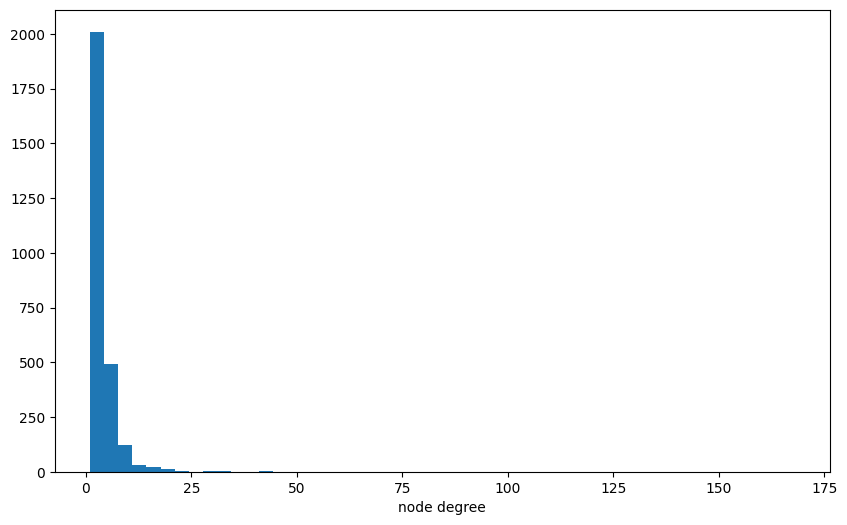

In [22]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

Un grado alto significa que están conectados a muchos nodos (artículos). En otras palabras, es probable que los nodos con un grado alto sean importantes. Recuerde que, al buscar artículos, siempre puede inferir qué tan bueno o malo es un artículo al observar cuántas veces ha sido citado.

Dibujemos el gráfico para ver dónde se ubican los 10 nodos principales con el grado más alto.

threshold 0.011821204285186553


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


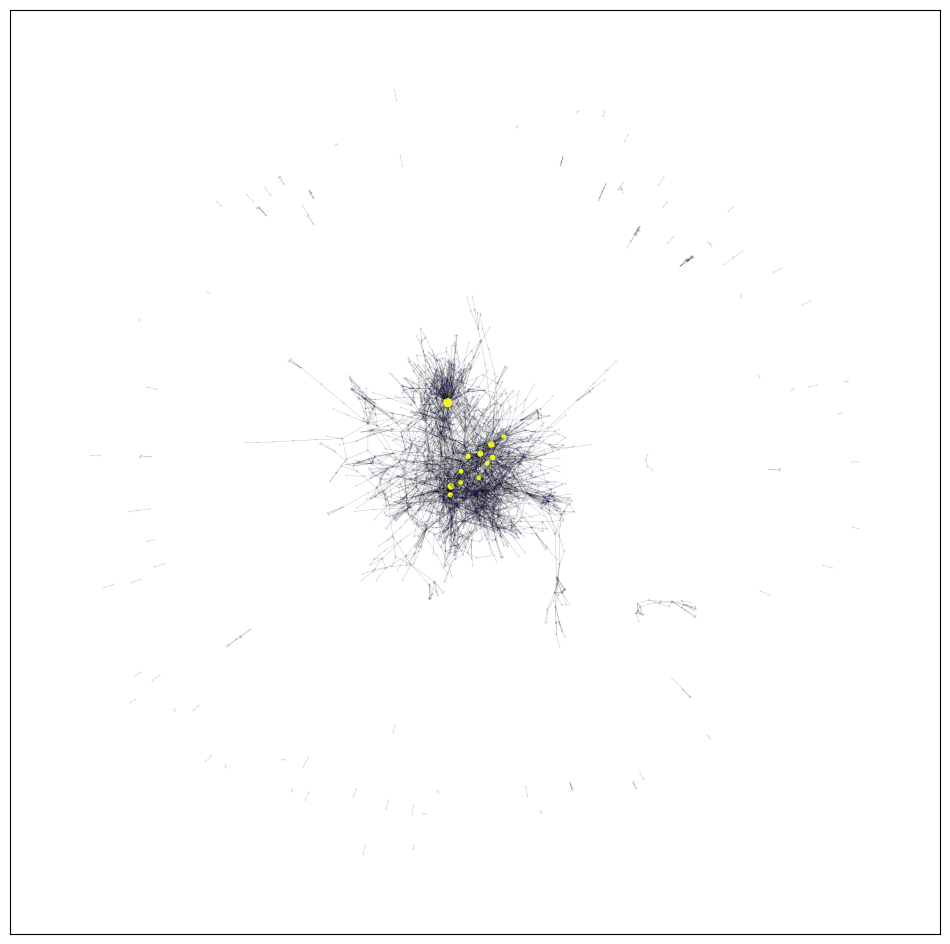

In [25]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

Los 10 nodos superiores con el grado más alto están representados por puntos amarillos, y los demás nodos están representados por puntos grises. Los puntos amarillos son proporcionales al tamaño del grado. Puedes ver que todos los puntos amarillos están ubicados en la parte central de la red.

**Features**

Los artículos del conjunto de datos de Cora tienen 1433 características.

Para cada una de las 1433 palabras, la cantidad de características se expresa como 0 y 1 si la palabra está incluida o no en el artículo.

In [26]:
print(f'Number of features: {data.num_node_features}')
# Number of edge features: 0

Number of features: 1433


Mostremos algunas de las características. Puedes ver que están compuestas de 0 y 1.

In [28]:
print(len(data.x[0]))
data.x[0][:20]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])

Tenga en cuenta que ahora estamos analizando las características de los nodos. Los bordes también pueden tener valores de características (características de borde), pero no están incluidos en el conjunto de datos de Cora.

**clases**

Los artículos del conjunto de datos Cora están etiquetados con 7 etiquetas diferentes.


In [29]:
print(f'Number of classes: {dataset.num_classes}')
# Number of classes: 7

Number of classes: 7


Vamos a mostrar una parte de la clase y podemos ver que consta de números enteros entre 0 y 6. Cada número corresponde a un tema, como se muestra a continuación. Para mayor información de las clases [ver aquí](https://keras.io/examples/graph/gnn_citations/)

In [30]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

A menudo, el número de clases no es igual. Averigüemos el número de cada clase.

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


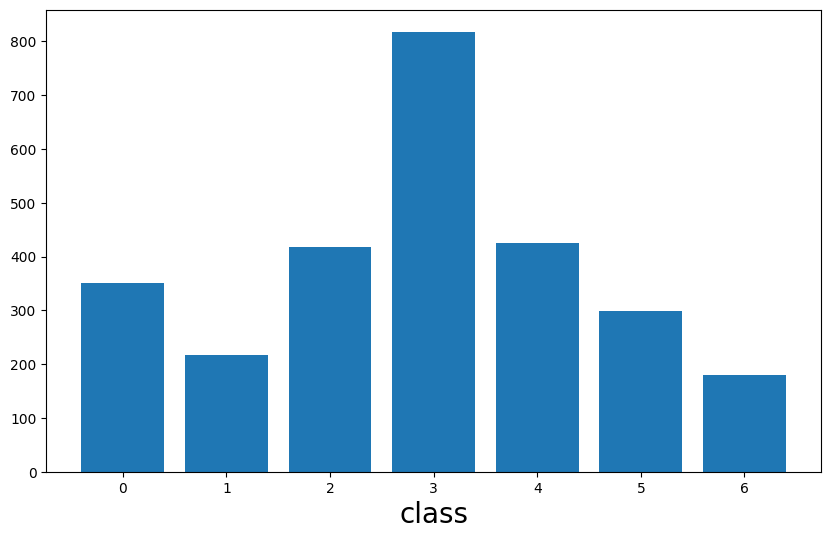

In [33]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

La mayor cantidad de clases es 818 en la clase 3 y la menor es 180 en la clase 6. Debemos tener cuidado al entrenar modelos de aprendizaje automático.

A continuación, dibuje un diagrama de red para ver si las clases están distribuidas de manera coherente.

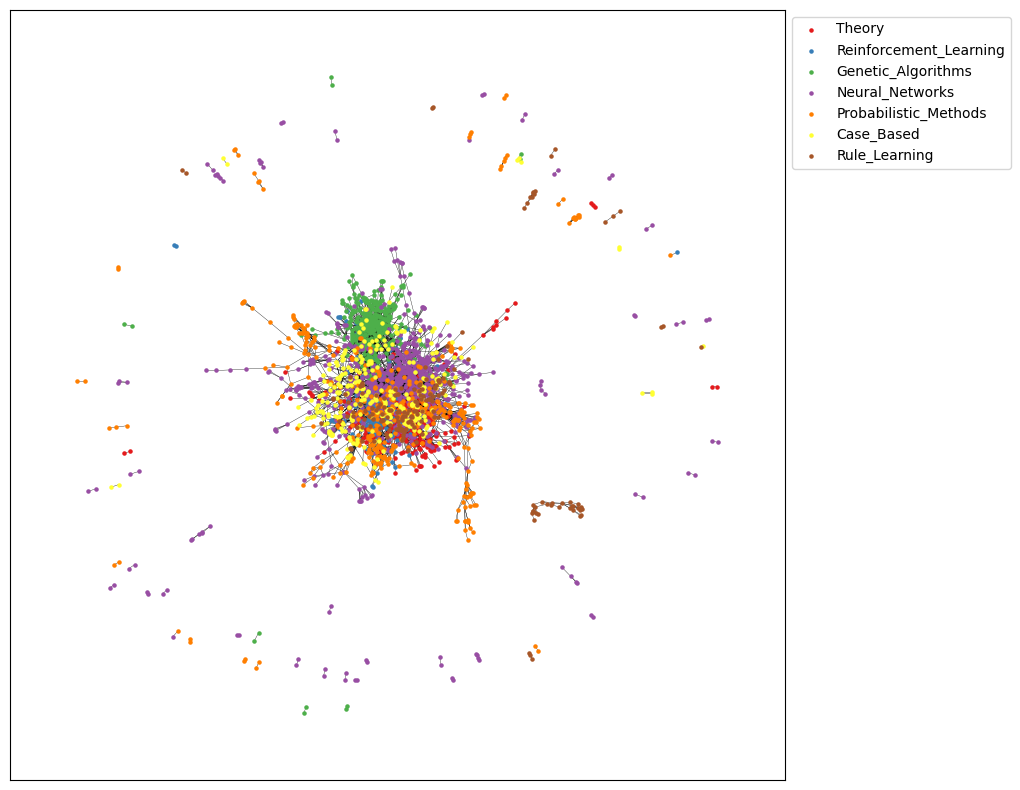

In [34]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

3. Arquitectura

* conv1: La primera capa GCNConv toma las características del nodo original $x$ y los índices de borde $edge\_index$ y asigna la entrada a un espacio oculto de tamaño $2 * out\_channels$. Esto se hace a menudo para aumentar la capacidad de representación del modelo. Después de aplicar la convolución, se aplica la activación $ReLU$ para introducir la no linealidad.
* conv2: La segunda capa GCNConv reduce la representación oculta de $2 * out\_channels$ a $out\_channels$, que es el tamaño de su espacio latente. Este resultado final son las incrustaciones de nodos $(z)$, que son una representación comprimida de las características de los nodos teniendo en cuenta la estructura del gráfico.


In [5]:
# Define the GCN Encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)


* $z$: Esta es la matriz de incrustaciones de nodos latentes (salida del codificador).

* $edge\_index$: Contiene los pares de nodos para los que queremos predecir si existe una arista.

* ***Producto escalar:*** El decodificador calcula el producto escalar entre las incrustaciones de pares de nodos $(i, j)$ para predecir si existe una arista. Si $z[i]$ y $z[j]$ son ​​similares (es decir, tienen un producto escalar grande), el modelo predice una mayor probabilidad de una arista entre esos nodos.

In [ ]:
def decoder(self, z, edge_index):
    # Decoder logic: inner product between node embeddings
    row, col = edge_index
    return (z[row] * z[col]).sum(dim=1)  # Dot product of node embeddings

In [6]:
# Split the data into train/test edges
data = dataset[0]
data1 = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None


In [7]:

# Print the edge information
print("Number of edges:", data.edge_index.size(1))  # Should be greater than 0
print("Edge indices:", data.edge_index)  # Print the edge indices

Number of edges: 10556
Edge indices: tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


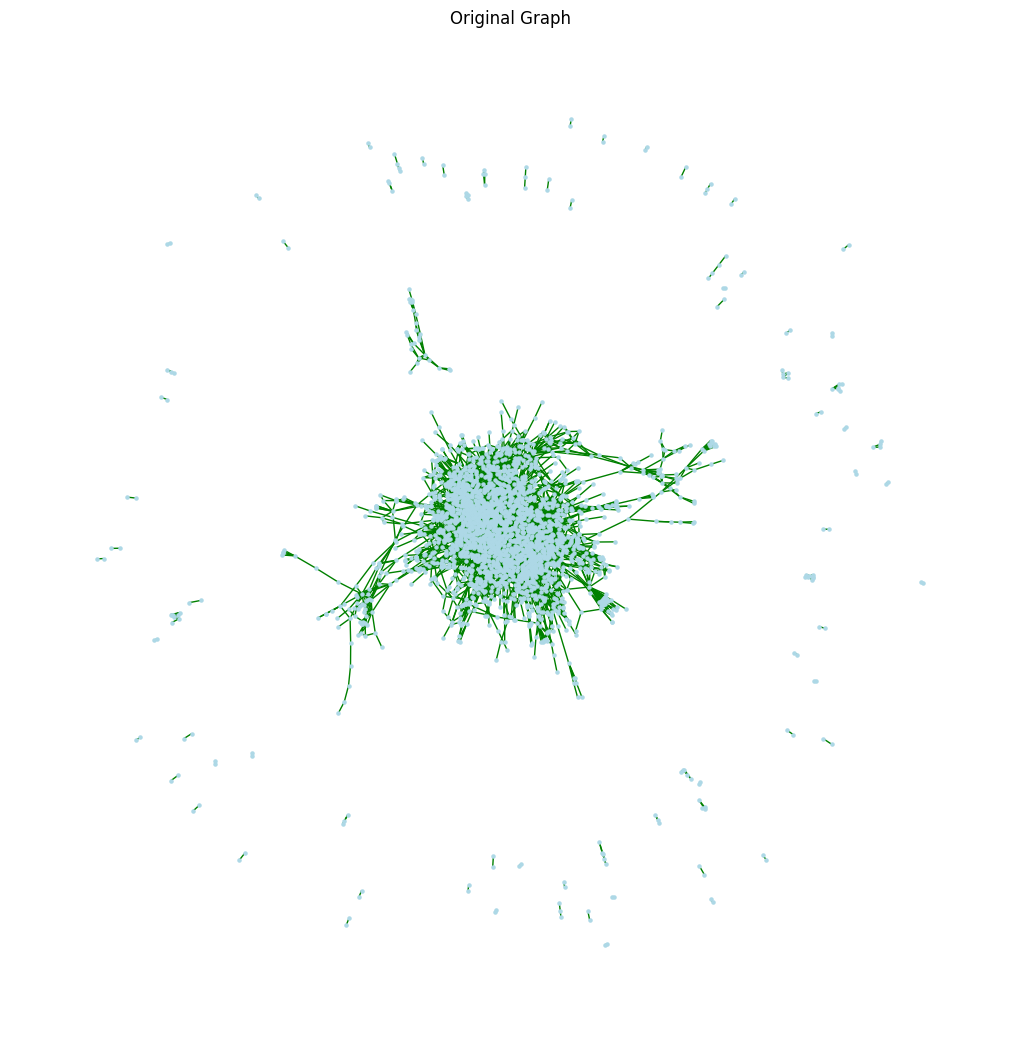

In [ ]:

# Visualize the Original Graph before splitting edges
def visualize_graph(data):
    G = to_networkx(data1, to_undirected=True)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='green', node_size=5)
    plt.title('Original Graph')
    plt.show()

# Call the graph visualization before splitting the edges
visualize_graph(data)


In [8]:
# Now split the data
data = train_test_split_edges(data)


# Define the model
out_channels = 16  # Dimension of latent space
num_features = dataset.num_features  # Number of input features (from Cora dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the encoder
encoder = GCNEncoder(in_channels=num_features, out_channels=out_channels)

# Create the GAE with the encoder
model = GAE(encoder).to(device)

# Move the data to the same device
data = data.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1433, 32)
    (conv2): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


In [9]:

# Visualize the edge indices after splitting
print("Training positive edge index shape:", data.train_pos_edge_index.size())
print("Testing positive edge index shape:", data.test_pos_edge_index.size())


Training positive edge index shape: torch.Size([2, 8976])
Testing positive edge index shape: torch.Size([2, 527])


In [10]:

# Visualize predicted links after training
def visualize_link_prediction(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

    # Sample some negative edges for comparison
    pos_edge_index = data.test_pos_edge_index #Positive loss: How well we predict the existence of actual edges (positive edges)
    neg_edge_index = negative_sampling( ## Negative loss: Sample negative edges and ensure the model predicts no edge between them
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )

    # Visualize positive and negative edges
    G = to_networkx(data1, to_undirected=True)

    pos = nx.spring_layout(G)

    plt.figure(figsize=(10, 10))

    # Draw original graph nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=5)

    # Draw positive (real) edges
    real_edges = pos_edge_index.cpu().numpy().T
    nx.draw_networkx_edges(G, pos, edgelist=real_edges, edge_color='green', label="True Edges")

    # Draw predicted negative edges
    pred_edges = neg_edge_index.cpu().numpy().T
    nx.draw_networkx_edges(G, pos, edgelist=pred_edges, edge_color='red', alpha=0.5, label="Predicted Missing Edges")

    plt.title('Link Prediction Visualization (Green: True, Red: Predicted Missing)')
    plt.legend()
    plt.show()



In [12]:

def train():
    model.train()
    optimizer.zero_grad()

    # Encode node embeddings
    z = model.encode(data.x, data.train_pos_edge_index)

    # Compute the reconstruction loss
    loss = model.recon_loss(z, data.train_pos_edge_index)

    loss.backward()
    optimizer.step()

    return loss

# Testing loop (similar checks can be added here if needed)
def test():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)
    return auc, ap

# Training for 200 epochs
for epoch in range(1, 201):
    loss = train()
    auc, ap = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')



Epoch: 001, Loss: 1.3650, AUC: 0.7005, AP: 0.7228
Epoch: 002, Loss: 1.8580, AUC: 0.7299, AP: 0.7413
Epoch: 003, Loss: 1.3204, AUC: 0.6849, AP: 0.7101
Epoch: 004, Loss: 1.4388, AUC: 0.6943, AP: 0.7183
Epoch: 005, Loss: 1.3646, AUC: 0.7194, AP: 0.7379
Epoch: 006, Loss: 1.3236, AUC: 0.7628, AP: 0.7702
Epoch: 007, Loss: 1.3277, AUC: 0.8032, AP: 0.8027
Epoch: 008, Loss: 1.3307, AUC: 0.8232, AP: 0.8222
Epoch: 009, Loss: 1.3243, AUC: 0.8238, AP: 0.8235
Epoch: 010, Loss: 1.3096, AUC: 0.8163, AP: 0.8146
Epoch: 011, Loss: 1.2879, AUC: 0.8097, AP: 0.8069
Epoch: 012, Loss: 1.2645, AUC: 0.8127, AP: 0.8095
Epoch: 013, Loss: 1.2337, AUC: 0.8238, AP: 0.8203
Epoch: 014, Loss: 1.2060, AUC: 0.8369, AP: 0.8326
Epoch: 015, Loss: 1.1752, AUC: 0.8440, AP: 0.8368
Epoch: 016, Loss: 1.1572, AUC: 0.8453, AP: 0.8346
Epoch: 017, Loss: 1.1403, AUC: 0.8465, AP: 0.8361
Epoch: 018, Loss: 1.1282, AUC: 0.8485, AP: 0.8408
Epoch: 019, Loss: 1.1066, AUC: 0.8490, AP: 0.8428
Epoch: 020, Loss: 1.0979, AUC: 0.8504, AP: 0.8444


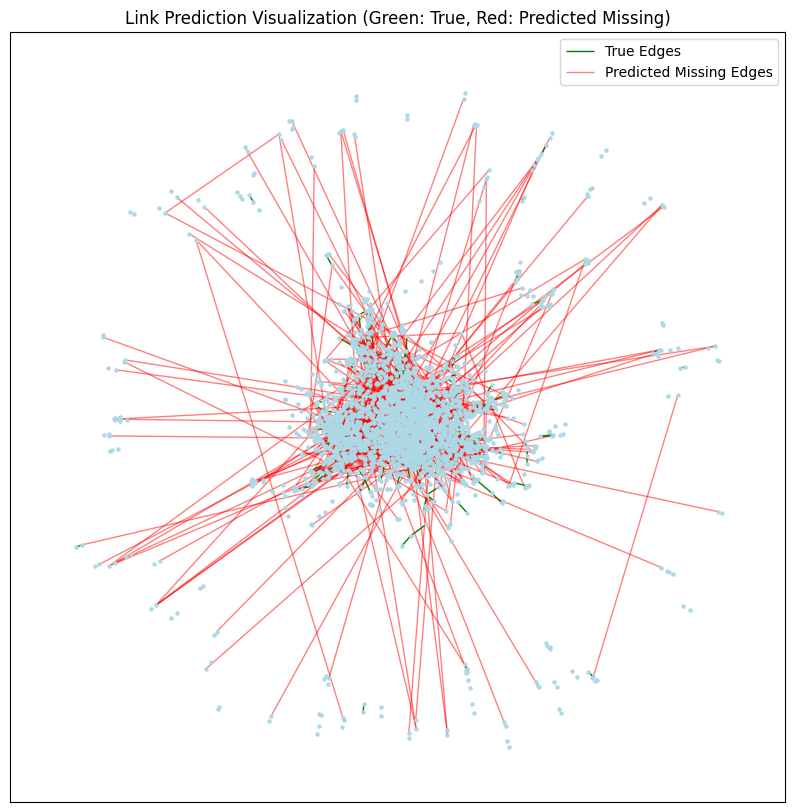

In [ ]:

# Visualize link prediction after training
visualize_link_prediction(model, data)